In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sympy.stats import *
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
import datetime
from datetime import date, timedelta
import os
import time
import warnings
import requests
from bs4 import BeautifulSoup
from sympy.stats import Bernoulli, density
from sympy import S
from scipy.stats import *

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

In [3]:
sched = pd.read_csv(r"C:\Users\Jordan\AppData\Local\Programs\Python\Python37\schedule_nba.csv") 
pbp = pd.read_csv(r"C:\Users\Jordan\AppData\Local\Programs\Python\Python37\seasoned_data.csv") 
pbp['game_id'] = pd.to_numeric(pbp['game_id'], errors='coerce')
pbp['game_id'].fillna(0, inplace = True)
pbp['game_id'] = pbp['game_id'].astype(int)

pbp.head()

,game_id,data_set,date,a1,a2,a3,a4,a5,h1,h2,h3,h4,h5,period,away_score,home_score,remaining_time,elapsed,play_length,play_id,team,event_type,assist,away,home,block,entered,left,num,opponent,outof,player,points,possession,reason,result,steal,type,shot_distance,original_x,original_y,converted_x,converted_y,description
0,21900001,2019-2020 Regular Season,10/22/2019,Jrue Holiday,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,OG Anunoby,Pascal Siakam,Marc Gasol,Kyle Lowry,Fred VanVleet,1,0,0,0:12:00,0:00:00,0:00:00,2,NaN,start of period,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,start of period,NaN,NaN,NaN,NaN,NaN,NaN
1,21900001,2019-2020 Regular Season,10/22/2019,Jrue Holiday,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,OG Anunoby,Pascal Siakam,Marc Gasol,Kyle Lowry,Fred VanVleet,1,0,0,0:12:00,0:00:00,0:00:00,4,NOP,jump ball,NaN,Derrick Favors,Marc Gasol,NaN,NaN,NaN,NaN,NaN,NaN,Marc Gasol,NaN,Lonzo Ball,NaN,NaN,NaN,jump ball,NaN,NaN,NaN,NaN,NaN,Jump Ball Gasol vs. Favors: Tip to Ball
2,21900001,2019-2020 Regular Season,10/22/2019,Jrue Holiday,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,OG Anunoby,Pascal Siakam,Marc Gasol,Kyle Lowry,Fred VanVleet,1,0,0,0:11:48,0:00:12,0:00:12,7,NOP,miss,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lonzo Ball,0.0,NaN,NaN,missed,NaN,unknown,11.0,2.0,114.0,24.8,16.4,MISS Ball 11' Driving Floating Jump Shot
3,21900001,2019-2020 Regular Season,10/22/2019,Jrue Holiday,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,OG Anunoby,Pascal Siakam,Marc Gasol,Kyle Lowry,Fred VanVleet,1,0,0,0:11:47,0:00:13,0:00:01,8,NOP,rebound,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Derrick Favors,NaN,NaN,NaN,NaN,NaN,rebound offensive,NaN,NaN,NaN,NaN,NaN,Favors REBOUND (Off:1 Def:0)
4,21900001,2019-2020 Regular Season,10/22/2019,Jrue Holiday,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,OG Anunoby,Pascal Siakam,Marc Gasol,Kyle Lowry,Fred VanVleet,1,2,0,0:11:47,0:00:13,0:00:00,9,NOP,shot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Derrick Favors,2.0,NaN,NaN,made,NaN,unknown,1.0,0.0,-6.0,25.0,4.4,Favors 1' Tip Layup Shot (2 PTS)


In [4]:
##Create Update Merged DF

merged = pd.merge(pbp, sched, on='game_id')

merged['home_lineup'] = merged['h1'] + ", " + merged['h2'] + ", " + merged['h3'] + ", " + merged['h4'] + ", " + merged['h5'] 
merged['away_lineup'] = merged['a1'] + ", " + merged['a2'] + ", " + merged['a3'] + ", " + merged['a4'] + ", " + merged['a5'] 

merged = merged[merged['play_length'] != '00:-12:00']
merged = merged[merged['play_length'] != '00:-5:00']

merged['play_start'] = pd.to_datetime(merged['elapsed'], format='%H:%M:%S') - pd.to_datetime(merged['play_length'], format='%H:%M:%S')
merged['play_end'] = pd.to_datetime(merged['elapsed'], format='%H:%M:%S')


period_dictionary ={1 : pd.to_datetime("00:00:00", format='%H:%M:%S'),
                    2 : pd.to_datetime("00:12:00", format='%H:%M:%S'), 
                    3 : pd.to_datetime("00:24:00", format='%H:%M:%S'),
                    4 : pd.to_datetime("00:36:00", format='%H:%M:%S')} 

merged['running'] = merged['period'].map(period_dictionary)


merged['play_start'] = merged['play_start'] + merged['running']

teams = ['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']

merged[merged['period']==2].head()

,game_id,data_set,date_x,a1,a2,a3,a4,a5,h1,h2,h3,h4,h5,period,away_score,home_score,remaining_time,elapsed,play_length,play_id,team,event_type,assist,away,home,block,entered,left,num,opponent,outof,player,points,possession,reason,result,steal,type,shot_distance,original_x,original_y,converted_x,converted_y,description,date_y,home_abbrev,away_abbrev,home_lineup,away_lineup,play_start,play_end,running
139,21900001,2019-2020 Regular Season,10/22/2019,Josh Hart,Jahlil Okafor,E'Twaun Moore,Nickeil Alexander-Walker,Kenrich Williams,OG Anunoby,Marc Gasol,Kyle Lowry,Serge Ibaka,Norman Powell,2,30,27,0:11:38,0:00:22,0:00:22,188,TOR,miss,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OG Anunoby,0.0,NaN,NaN,missed,NaN,Driving Finger Roll Layup,1.0,6.0,4.0,25.6,88.6,MISS Anunoby 1' Driving Finger Roll Layup,10/22/2019,TOR,NOP,"OG Anunoby, Marc Gasol, Kyle Lowry, Serge Ibak...","Josh Hart, Jahlil Okafor, E'Twaun Moore, Nicke...",1900-01-01 00:12:00,1900-01-01 00:00:22,1900-01-01 00:12:00
140,21900001,2019-2020 Regular Season,10/22/2019,Josh Hart,Jahlil Okafor,E'Twaun Moore,Nickeil Alexander-Walker,Kenrich Williams,OG Anunoby,Marc Gasol,Kyle Lowry,Serge Ibaka,Norman Powell,2,30,27,0:11:35,0:00:25,0:00:03,189,TOR,rebound,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marc Gasol,NaN,NaN,NaN,NaN,NaN,rebound offensive,NaN,NaN,NaN,NaN,NaN,Gasol REBOUND (Off:1 Def:1),10/22/2019,TOR,NOP,"OG Anunoby, Marc Gasol, Kyle Lowry, Serge Ibak...","Josh Hart, Jahlil Okafor, E'Twaun Moore, Nicke...",1900-01-01 00:12:22,1900-01-01 00:00:25,1900-01-01 00:12:00
141,21900001,2019-2020 Regular Season,10/22/2019,Josh Hart,Jahlil Okafor,E'Twaun Moore,Nickeil Alexander-Walker,Kenrich Williams,OG Anunoby,Marc Gasol,Kyle Lowry,Serge Ibaka,Norman Powell,2,30,27,0:11:35,0:00:25,0:00:00,190,TOR,miss,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marc Gasol,0.0,NaN,NaN,missed,NaN,unknown,1.0,0.0,-6.0,25.0,89.6,MISS Gasol 1' Tip Layup Shot,10/22/2019,TOR,NOP,"OG Anunoby, Marc Gasol, Kyle Lowry, Serge Ibak...","Josh Hart, Jahlil Okafor, E'Twaun Moore, Nicke...",1900-01-01 00:12:25,1900-01-01 00:00:25,1900-01-01 00:12:00
142,21900001,2019-2020 Regular Season,10/22/2019,Josh Hart,Jahlil Okafor,E'Twaun Moore,Nickeil Alexander-Walker,Kenrich Williams,OG Anunoby,Marc Gasol,Kyle Lowry,Serge Ibaka,Norman Powell,2,30,27,0:11:34,0:00:26,0:00:01,191,TOR,rebound,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kyle Lowry,NaN,NaN,NaN,NaN,NaN,rebound offensive,NaN,NaN,NaN,NaN,NaN,Lowry REBOUND (Off:1 Def:3),10/22/2019,TOR,NOP,"OG Anunoby, Marc Gasol, Kyle Lowry, Serge Ibak...","Josh Hart, Jahlil Okafor, E'Twaun Moore, Nicke...",1900-01-01 00:12:25,1900-01-01 00:00:26,1900-01-01 00:12:00
143,21900001,2019-2020 Regular Season,10/22/2019,Josh Hart,Jahlil Okafor,E'Twaun Moore,Nickeil Alexander-Walker,Kenrich Williams,OG Anunoby,Marc Gasol,Kyle Lowry,Serge Ibaka,Norman Powell,2,30,27,0:11:33,0:00:27,0:00:01,192,TOR,miss,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Norman Powell,0.0,NaN,NaN,missed,NaN,Jump Shot,26.0,-71.0,251.0,17.9,63.9,MISS Powell 26' 3PT Jump Shot,10/22/2019,TOR,NOP,"OG Anunoby, Marc Gasol, Kyle Lowry, Serge Ibak...","Josh Hart, Jahlil Okafor, E'Twaun Moore, Nicke...",1900-01-01 00:12:26,1900-01-01 00:00:27,1900-01-01 00:12:00


In [5]:
def calc_stats(refined_query):    
    teammates = refined_query['team_lineup'].unique()
    teammates = teammates.tolist()
    teammates = [i.split(", ") for i in teammates]
    flat_teammates = [item for sublist in teammates for item in sublist]
    flat_teammates = list(dict.fromkeys(flat_teammates)) #removed the flat_teammates print call, left variable alone

    min_log = []
    game_log = []
    point_log = []
    assist_log = []
    rebound_log = []
    block_log = []
    steal_log = []
    turnover_log = []      
    three_log = []
    fgm_log = []
    miss_log = []
    assisting_log = []
    zero_three_log = []
    four_nine_log = []
    ten_fifteen_log = []
    sixteen_twentythree_log = []
    twentyfour_twentynine_log = []
    thirty_plus_log = []
    zero_three_miss_log = []
    four_nine_miss_log = []
    ten_fifteen_miss_log = []
    sixteen_twentythree_miss_log = []
    twentyfour_twentynine_miss_log = []
    thirty_plus_miss_log = []

    for i in flat_teammates: #minutes played
        player_search = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        player_search['play_length'] = pd.to_datetime(player_search['play_length'], format='%H:%M:%S')
        secs_player = player_search['play_length'].dt.second.sum()
        min_log.append((secs_player)/60)
        

    for i in flat_teammates: #number of games played
        game_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        game_played = game_count['game_id'].nunique()
        game_log.append(game_played)
        

    for i in flat_teammates: #number of FGM
        fgm_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        fgm_count = fgm_count[fgm_count['player']==i]
        fgm_count = fgm_count[fgm_count['event_type']=='shot']
        fgm_no = len(fgm_count)
        fgm_log.append(fgm_no)
        

    for i in flat_teammates: #number of misses
        miss_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        miss_count = miss_count[miss_count['player']==i]
        miss_count = miss_count[miss_count['event_type']=='miss']
        miss_no = len(miss_count)
        miss_log.append(miss_no)
        

    for i in flat_teammates: #total points scored
        point_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        player_shots = point_count[point_count['player']==i]
        points = player_shots['points'].sum()
        point_log.append(points)
        

    for i in flat_teammates: #3 pointers scored
        three_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        three_count = three_count[three_count['player']==i]
        three_count = three_count[three_count['points']==3]
        threes = three_count['points'].sum()
        three_no = threes / 3
        three_log.append(three_no)
        

    for i in flat_teammates: #assists
        assist_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        assist_count = assist_count[assist_count['assist'].str.contains(i, na=False)==True]
        assist_no = len(assist_count)
        assist_log.append(assist_no)

        
    for i in flat_teammates: #rebounds
        rebound_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        rebound_count = rebound_count[rebound_count['player'].str.contains(i, na=False)==True]
        rebound_count = rebound_count[rebound_count['event_type']=='rebound']
        rebound_no = len(rebound_count)
        rebound_log.append(rebound_no)

        
    for i in flat_teammates: #steals
        steal_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        steal_count = steal_count[steal_count['steal'].str.contains(i, na=False)==True]
        steal_no = len(steal_count)
        steal_log.append(steal_no)

        
    for i in flat_teammates: #blocks
        block_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        block_count = block_count[block_count['block'].str.contains(i, na=False)==True]
        block_no = len(block_count)
        block_log.append(block_no)
        

    for i in flat_teammates: #turnovers
        turnover_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        turnover_count = turnover_count[turnover_count['player'].str.contains(i, na=False)==True]
        turnover_count = turnover_count[turnover_count['event_type']=='turnover']
        turnover_no = len(turnover_count)
        turnover_log.append(turnover_no)

        
    for i in flat_teammates: #unassisted fg
        assisting_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        assisting_count = assisting_count[assisting_count['player']==i]
        assisting_count = assisting_count[assisting_count['event_type']=='shot']
        assisting_no = assisting_count['assist'].isnull().sum()
        assisting_log.append(assisting_no)    
        
        
    for i in flat_teammates: #0-3
        zero_three_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        zero_three_count = zero_three_count[zero_three_count['player']==i]
        zero_three_count = zero_three_count[zero_three_count['event_type']=='shot']
        zero_three_count = zero_three_count[(zero_three_count['shot_distance'] >= 0) & (zero_three_count['shot_distance'] <=3)]
        zero_three_no = len(zero_three_count)
        zero_three_log.append(zero_three_no)
        
        
    for i in flat_teammates: #4-9
        four_nine_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        four_nine_count = four_nine_count[four_nine_count['player']==i]
        four_nine_count = four_nine_count[four_nine_count['event_type']=='shot']
        four_nine_count = four_nine_count[(four_nine_count['shot_distance'] >= 4) & (four_nine_count['shot_distance'] <=9)]
        four_nine_no = len(four_nine_count)
        four_nine_log.append(four_nine_no)    

        
    for i in flat_teammates: #10-15
        ten_fifteen_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        ten_fifteen_count = ten_fifteen_count[ten_fifteen_count['player']==i]
        ten_fifteen_count = ten_fifteen_count[ten_fifteen_count['event_type']=='shot']
        ten_fifteen_count = ten_fifteen_count[(ten_fifteen_count['shot_distance'] >= 10) & (ten_fifteen_count['shot_distance'] <= 15)]
        ten_fifteen_no = len(ten_fifteen_count)
        ten_fifteen_log.append(ten_fifteen_no)   
        
        
    for i in flat_teammates: #16-23
        sixteen_twentythree_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        sixteen_twentythree_count = sixteen_twentythree_count[sixteen_twentythree_count['player']==i]
        sixteen_twentythree_count = sixteen_twentythree_count[sixteen_twentythree_count['event_type']=='shot']
        sixteen_twentythree_count = sixteen_twentythree_count[(sixteen_twentythree_count['shot_distance'] >= 16) & (sixteen_twentythree_count['shot_distance'] <= 23)]
        sixteen_twentythree_no = len(sixteen_twentythree_count)
        sixteen_twentythree_log.append(sixteen_twentythree_no)     
        
        
    for i in flat_teammates: #24-29
        twentyfour_twentynine_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        twentyfour_twentynine_count = twentyfour_twentynine_count[twentyfour_twentynine_count['player']==i]
        twentyfour_twentynine_count = twentyfour_twentynine_count[twentyfour_twentynine_count['event_type']=='shot']
        twentyfour_twentynine_count = twentyfour_twentynine_count[(twentyfour_twentynine_count['shot_distance'] >= 24) & (twentyfour_twentynine_count['shot_distance'] <= 29)]
        twentyfour_twentynine_no = len(twentyfour_twentynine_count)
        twentyfour_twentynine_log.append(twentyfour_twentynine_no)  

        
    for i in flat_teammates: #30+
        thirty_plus_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        thirty_plus_count = thirty_plus_count[thirty_plus_count['player']==i]
        thirty_plus_count = thirty_plus_count[thirty_plus_count['event_type']=='shot']
        thirty_plus_count = thirty_plus_count[(thirty_plus_count['shot_distance'] >= 30)]
        thirty_plus_no = len(thirty_plus_count)
        thirty_plus_log.append(thirty_plus_no)  
        

    for i in flat_teammates: #0-3 miss
        zero_three_miss_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        zero_three_miss_count = zero_three_miss_count[zero_three_miss_count['player']==i]
        zero_three_miss_count = zero_three_miss_count[zero_three_miss_count['event_type']=='miss']
        zero_three_miss_count = zero_three_miss_count[(zero_three_miss_count['shot_distance'] >= 0) & (zero_three_miss_count['shot_distance'] <=3)]
        zero_three_miss_no = len(zero_three_miss_count)
        zero_three_miss_log.append(zero_three_miss_no)
        
        
    for i in flat_teammates: #4-9 miss
        four_nine_miss_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        four_nine_miss_count = four_nine_miss_count[four_nine_miss_count['player']==i]
        four_nine_miss_count = four_nine_miss_count[four_nine_miss_count['event_type']=='miss']
        four_nine_miss_count = four_nine_miss_count[(four_nine_miss_count['shot_distance'] >= 4) & (four_nine_miss_count['shot_distance'] <=9)]
        four_nine_miss_no = len(four_nine_miss_count)
        four_nine_miss_log.append(four_nine_miss_no)    

        
    for i in flat_teammates: #10-15 miss
        ten_fifteen_miss_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        ten_fifteen_miss_count = ten_fifteen_miss_count[ten_fifteen_miss_count['player']==i]
        ten_fifteen_miss_count = ten_fifteen_miss_count[ten_fifteen_miss_count['event_type']=='miss']
        ten_fifteen_miss_count = ten_fifteen_miss_count[(ten_fifteen_miss_count['shot_distance'] >= 10) & (ten_fifteen_miss_count['shot_distance'] <= 15)]
        ten_fifteen_miss_no = len(ten_fifteen_miss_count)
        ten_fifteen_miss_log.append(ten_fifteen_miss_no)   
        
        
    for i in flat_teammates: #16-23 miss
        sixteen_twentythree_miss_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        sixteen_twentythree_miss_count = sixteen_twentythree_miss_count[sixteen_twentythree_miss_count['player']==i]
        sixteen_twentythree_miss_count = sixteen_twentythree_miss_count[sixteen_twentythree_miss_count['event_type']=='miss']
        sixteen_twentythree_miss_count = sixteen_twentythree_miss_count[(sixteen_twentythree_miss_count['shot_distance'] >= 16) & (sixteen_twentythree_miss_count['shot_distance'] <= 23)]
        sixteen_twentythree_miss_no = len(sixteen_twentythree_miss_count)
        sixteen_twentythree_miss_log.append(sixteen_twentythree_miss_no)     
        
        
    for i in flat_teammates: #24-29 miss
        twentyfour_twentynine_miss_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        twentyfour_twentynine_miss_count = twentyfour_twentynine_miss_count[twentyfour_twentynine_miss_count['player']==i]
        twentyfour_twentynine_miss_count = twentyfour_twentynine_miss_count[twentyfour_twentynine_miss_count['event_type']=='miss']
        twentyfour_twentynine_miss_count = twentyfour_twentynine_miss_count[(twentyfour_twentynine_miss_count['shot_distance'] >= 24) & (twentyfour_twentynine_miss_count['shot_distance'] <= 29)]
        twentyfour_twentynine_miss_no = len(twentyfour_twentynine_miss_count)
        twentyfour_twentynine_miss_log.append(twentyfour_twentynine_miss_no)  

        
    for i in flat_teammates: #30+ _miss
        thirty_plus_miss_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        thirty_plus_miss_count = thirty_plus_miss_count[thirty_plus_miss_count['player']==i]
        thirty_plus_miss_count = thirty_plus_miss_count[thirty_plus_miss_count['event_type']=='miss']
        thirty_plus_miss_count = thirty_plus_miss_count[(thirty_plus_miss_count['shot_distance'] >= 30)]
        thirty_plus_miss_no = len(thirty_plus_miss_count)
        thirty_plus_miss_log.append(thirty_plus_miss_no)          
        
    wowy_log = pd.DataFrame(list(map(list, zip(flat_teammates, game_log, fgm_log, miss_log, min_log, point_log, three_log, assist_log, rebound_log, block_log, steal_log, turnover_log, assisting_log, zero_three_log, zero_three_miss_log, four_nine_log, four_nine_miss_log, ten_fifteen_log, ten_fifteen_miss_log, sixteen_twentythree_log, sixteen_twentythree_miss_log, twentyfour_twentynine_log, twentyfour_twentynine_miss_log, thirty_plus_log, thirty_plus_miss_log))))
    wowy_log.columns = ['Player', 'GP', 'FGM', 'MISS', 'MIN', 'PTS', 
                        'TPM', 'AST', 'REB', 'BLK', 'STL', 'TOV', 
                        'UA', '0-3 Made', '0-3 Miss', '4-9 Made', 
                        '4-9 Miss', '10-15 Made', '10-15 Miss', 
                        '16-23 Made', '16-23 Miss', '24-29 Made', 
                        '24-29 Miss', '30+ Made', '30+ Miss']
    
    wowy_log['MPG'] = wowy_log['MIN'] / wowy_log['GP']
    wowy_log['MIN'] = wowy_log['MIN'].round(2)
    wowy_log['MPG'] = wowy_log['MPG'].round(2)
    wowy_log['FGA'] = wowy_log['FGM'] + wowy_log['MISS']
    wowy_log['FG%'] = wowy_log['FGM'] / wowy_log['FGA']
    wowy_log['FG%'] = wowy_log['FG%'].round(2)
    wowy_log['A'] =  wowy_log['FGM'] - wowy_log['UA']
    wowy_log['%A'] = wowy_log['A'] / wowy_log['FGM']
    wowy_log['%A'] = wowy_log['%A'].round(3)
    wowy_log['0-3 Att.'] = wowy_log['0-3 Miss'] + wowy_log['0-3 Made']
    wowy_log['0-3 FG%'] = wowy_log['0-3 Made'] / wowy_log['0-3 Att.']
    wowy_log['0-3 FG%'] = round(wowy_log['0-3 FG%'], 2)
    wowy_log['4-9 Att.'] = wowy_log['4-9 Miss'] + wowy_log['4-9 Made']
    wowy_log['4-9 FG%'] = wowy_log['4-9 Made'] / wowy_log['4-9 Att.']
    wowy_log['4-9 FG%'] = round(wowy_log['4-9 FG%'], 2)
    wowy_log['10-15 Att.'] = wowy_log['10-15 Miss'] + wowy_log['10-15 Made']
    wowy_log['10-15 FG%'] = wowy_log['10-15 Made'] / wowy_log['10-15 Att.']
    wowy_log['10-15 FG%'] = round(wowy_log['10-15 FG%'],2)
    wowy_log['16-23 Att.'] = wowy_log['16-23 Miss'] + wowy_log['16-23 Made']
    wowy_log['16-23 FG%'] = wowy_log['16-23 Made'] / wowy_log['16-23 Att.']
    wowy_log['16-23 FG%'] = round(wowy_log['16-23 FG%'], 2)
    wowy_log['24-29 Att.'] = wowy_log['24-29 Miss'] + wowy_log['24-29 Made']
    wowy_log['24-29 FG%'] = wowy_log['24-29 Made'] / wowy_log['24-29 Att.']
    wowy_log['24-29 FG%'] = round(wowy_log['24-29 FG%'], 2)
    wowy_log['30+ Att.'] = wowy_log['30+ Miss'] + wowy_log['30+ Made']
    wowy_log['30+ FG%'] = wowy_log['30+ Made'] / wowy_log['30+ Att.']
    wowy_log['30+ FG%'] = round(wowy_log['30+ FG%'], 2)
    wowy_log['DKFP'] = (wowy_log['PTS'] * 1) + (wowy_log['REB'] * 1.25) + (wowy_log['AST'] * 1.5) + (wowy_log['STL'] * 2) + (wowy_log['BLK'] * 2) + (wowy_log['TPM'] * .5) + (wowy_log['TOV'] * -0.5)
    wowy_log['DKFP'] = round(wowy_log['DKFP'], 2)
    wowy_log['% 0-3'] = wowy_log['0-3 Att.'] / wowy_log['FGA']
    wowy_log['% 0-3'] = round(wowy_log['% 0-3'], 2)
    wowy_log['% 4-9'] = wowy_log['4-9 Att.'] / wowy_log['FGA']
    wowy_log['% 4-9'] = round(wowy_log['% 4-9'], 2)
    wowy_log['% 10-15'] = wowy_log['10-15 Att.'] / wowy_log['FGA']
    wowy_log['% 10-15'] = round(wowy_log['% 10-15'], 2)
    wowy_log['% 16-23'] = wowy_log['16-23 Att.'] / wowy_log['FGA']
    wowy_log['% 16-23'] = round(wowy_log['% 16-23'], 2)
    wowy_log['% 24-29'] = wowy_log['24-29 Att.'] / wowy_log['FGA']
    wowy_log['% 24-29'] = round(wowy_log['% 24-29'], 2)
    wowy_log['% 30+'] = wowy_log['30+ Att.'] / wowy_log['FGA']
    wowy_log['% 30+'] = round(wowy_log['% 30+'], 2)
    
    pd.set_option('display.expand_frame_repr', False)
    
    columnsTitles = ['Player', 'GP', 'MIN', 'MPG', 'PTS', 'REB', 
                     'AST', 'BLK', 'STL', 'TOV', 'FGA', 'FGM', 
                     'FG%', 'TPM', 'DKFP', 'A', 'UA', '%A', '0-3 Att.',
                     '0-3 Made', '% 0-3', '0-3 FG%', '4-9 Att.',
                     '4-9 Made', '% 4-9', '4-9 FG%', '10-15 Att.',
                     '10-15 Made', '% 10-15', '10-15 FG%',
                     '16-23 Att.', '16-23 Made', '% 16-23',
                     '16-23 FG%', '24-29 Att.', '24-29 Made',
                     '% 24-29', '24-29 FG%', '30+ Att.',
                     '30+ Made', '% 30+', '30+ FG%']

    wowy_log = wowy_log.reindex(columns=columnsTitles)
    
    wowy_log = wowy_log.fillna(0)
    
    return wowy_log #Returned wowy_log rather than printed it
    



In [195]:
def team_stats(refined_query):    
    
    team_points = refined_query.groupby(['game_id','team'])['points'].sum()
    only_shots = refined_query[refined_query['event_type']=='shot']
    team_shots = only_shots.groupby(['game_id','team'])['event_type'].count()
    only_misses = refined_query[refined_query['event_type']=='miss']
    team_misses = only_misses.groupby(['game_id','team'])['event_type'].count()
    only_freethrow = refined_query[refined_query['event_type']=='free throw']
    team_freethrow = only_freethrow.groupby(['game_id','team'])['event_type'].count()
    only_turnover = refined_query[refined_query['event_type']=='turnover']
    team_turnover = only_turnover.groupby(['game_id','team'])['event_type'].count()
    only_foul = refined_query[refined_query['event_type']=='foul']
    team_foul = only_foul.groupby(['game_id','team'])['event_type'].count()
    only_orb = refined_query[refined_query['type']=='rebound offensive']
    team_orb = only_orb.groupby(['game_id','team'])['event_type'].count()
    only_drb = refined_query[refined_query['type']=='rebound defensive']
    team_drb = only_drb.groupby(['game_id','team'])['event_type'].count()
    only_no_assists = only_shots[only_shots['assist'].isna()==True]
    team_unassist = only_no_assists.groupby(['game_id','team'])['event_type'].count()

    team_stats = pd.concat([team_points, team_shots, team_misses, team_freethrow, team_turnover, team_foul, team_orb, team_drb, team_unassist], axis=1)
    team_stats.to_csv("team_stats.csv")
    team_stats = pd.read_csv("team_stats.csv") #This is a jerryrig lol

    team_stats.columns = ['game_id', 'Team', 'PTS', 'FGM', 'Miss', 'FTA', 'TOV', 'Foul', 'ORB', 'DRB', 'UA']
    team_stats['FGA'] = team_stats['FGM'] + team_stats['Miss']
    team_stats['FG%'] = team_stats['FGM'] / team_stats['FGA']
    team_stats['FG%'] = team_stats['FG%'].round(3)
    team_stats['A%'] = 1 - (team_stats['UA']/team_stats['FGM'])
    team_stats['A%'] = team_stats['A%'].round(3)


    team_stats['OPP_FGA'] = team_stats.groupby('game_id')['FGA'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_FTA'] = team_stats.groupby('game_id')['FTA'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_ORB'] = team_stats.groupby('game_id')['ORB'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_DRB'] = team_stats.groupby('game_id')['DRB'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_FGM'] = team_stats.groupby('game_id')['FGM'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_TOV'] = team_stats.groupby('game_id')['TOV'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)

    team_part = (team_stats['FGA'] + 0.4 * team_stats['FTA'] - 1.07 * (team_stats['ORB'] / (team_stats['ORB'] + team_stats['OPP_DRB'])) * (team_stats['FGA'] - team_stats['FGM']) + team_stats['TOV'])
    opp_part = (team_stats['OPP_FGA'] + 0.4 * team_stats['OPP_FTA'] - 1.07 * (team_stats['OPP_ORB'] / (team_stats['OPP_ORB'] + team_stats['DRB'])) * (team_stats['OPP_FGA'] - team_stats['OPP_FGM']) + team_stats['OPP_TOV'])


    team_stats['POSS'] = 0.5 * (team_part + opp_part)
    team_stats['POSS'] = team_stats['POSS'].round(2)
    
    
    team_stats = team_stats[team_stats['Team']==team]

    team_stats = team_stats.append(team_stats.sum(numeric_only=True), ignore_index=True) 
    
    return team_stats

In [196]:
def opp_stats(refined_query):    
    
    team_points = refined_query.groupby(['game_id','team'])['points'].sum()
    only_shots = refined_query[refined_query['event_type']=='shot']
    team_shots = only_shots.groupby(['game_id','team'])['event_type'].count()
    only_misses = refined_query[refined_query['event_type']=='miss']
    team_misses = only_misses.groupby(['game_id','team'])['event_type'].count()
    only_freethrow = refined_query[refined_query['event_type']=='free throw']
    team_freethrow = only_freethrow.groupby(['game_id','team'])['event_type'].count()
    only_turnover = refined_query[refined_query['event_type']=='turnover']
    team_turnover = only_turnover.groupby(['game_id','team'])['event_type'].count()
    only_foul = refined_query[refined_query['event_type']=='foul']
    team_foul = only_foul.groupby(['game_id','team'])['event_type'].count()
    only_orb = refined_query[refined_query['type']=='rebound offensive']
    team_orb = only_orb.groupby(['game_id','team'])['event_type'].count()
    only_drb = refined_query[refined_query['type']=='rebound defensive']
    team_drb = only_drb.groupby(['game_id','team'])['event_type'].count()
    only_no_assists = only_shots[only_shots['assist'].isna()==True]
    team_unassist = only_no_assists.groupby(['game_id','team'])['event_type'].count()

    team_stats = pd.concat([team_points, team_shots, team_misses, team_freethrow, team_turnover, team_foul, team_orb, team_drb, team_unassist], axis=1)
    team_stats.to_csv("team_stats.csv")
    team_stats = pd.read_csv("team_stats.csv") #This is a jerryrig lol

    team_stats.columns = ['game_id', 'Team', 'PTS', 'FGM', 'Miss', 'FTA', 'TOV', 'Foul', 'ORB', 'DRB', 'UA']
    team_stats['FGA'] = team_stats['FGM'] + team_stats['Miss']
    team_stats['FG%'] = team_stats['FGM'] / team_stats['FGA']
    team_stats['FG%'] = team_stats['FG%'].round(3)
    team_stats['A%'] = 1 - (team_stats['UA']/team_stats['FGM'])
    team_stats['A%'] = team_stats['A%'].round(3)


    team_stats['OPP_FGA'] = team_stats.groupby('game_id')['FGA'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_FTA'] = team_stats.groupby('game_id')['FTA'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_ORB'] = team_stats.groupby('game_id')['ORB'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_DRB'] = team_stats.groupby('game_id')['DRB'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_FGM'] = team_stats.groupby('game_id')['FGM'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_TOV'] = team_stats.groupby('game_id')['TOV'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)

    team_part = (team_stats['FGA'] + 0.4 * team_stats['FTA'] - 1.07 * (team_stats['ORB'] / (team_stats['ORB'] + team_stats['OPP_DRB'])) * (team_stats['FGA'] - team_stats['FGM']) + team_stats['TOV'])
    opp_part = (team_stats['OPP_FGA'] + 0.4 * team_stats['OPP_FTA'] - 1.07 * (team_stats['OPP_ORB'] / (team_stats['OPP_ORB'] + team_stats['DRB'])) * (team_stats['OPP_FGA'] - team_stats['OPP_FGM']) + team_stats['OPP_TOV'])


    team_stats['POSS'] = 0.5 * (team_part + opp_part)
    team_stats['POSS'] = team_stats['POSS'].round(2)
    
    
    team_stats = team_stats[team_stats['Team']!=team]

    team_stats = team_stats.append(team_stats.sum(numeric_only=True), ignore_index=True) 
    
    return team_stats

In [197]:
#Scraping lineup data


#URL to scrape from

url = "https://www.cbssports.com/nba/injuries/"

#Get URL HTML
response = requests.get(url)
print(response) # Response [200] means it went through

#Parse HTML with BeautifulSoup
soup = BeautifulSoup(response.text, "html.parser")

soup.prettify()

#Read in html as pandas data frame
inactives = pd.read_html(url)

inactives = pd.concat([inactives[0], inactives[1], inactives[2], inactives[3], inactives[4], inactives[5],
                       inactives[6], inactives[7], inactives[8], inactives[9], inactives[10], inactives[11],
                       inactives[12], inactives[13], inactives[14], inactives[15], inactives[16], inactives[17],
                       inactives[18], inactives[19], inactives[20], inactives[21], inactives[22], inactives[23],
                       inactives[24], inactives[25]])



new = inactives['Player'].str.split(' ', n = 5, expand = True)

inactives['first name'] = new[3]

inactives['second name'] = new[4]

inactives['full_name'] = inactives['first name'] + " " + inactives['second name']

injury_report = inactives['full_name'].tolist()

inactives.head(n=40)

<Response [200]>


,Player,Position,Updated,Injury,Injury Status,first name,second name,full_name
0,D. Bembry DeAndre' Bembry,SG,"Wed, Feb 5",Hand,Game Time Decision,DeAndre',Bembry,DeAndre' Bembry
1,J. Parker Jabari Parker,PF,"Wed, Feb 5",Shoulder,Game Time Decision,Jabari,Parker,Jabari Parker
2,B. Fernando Bruno Fernando,PF,"Wed, Feb 5",Calf,Expected to be out until at least Feb 7,Bruno,Fernando,Bruno Fernando
3,C. Reddish Cam Reddish,SG,"Wed, Feb 5",Concussion,Game Time Decision,Cam,Reddish,Cam Reddish
4,E. Turner Evan Turner,SG,"Wed, Feb 5",Not Injury Related,Game Time Decision,Evan,Turner,Evan Turner
5,A. Len Alex Len,C,"Wed, Feb 5",Hip,Game Time Decision,Alex,Len,Alex Len
0,J. Brown Jaylen Brown,SG,"Wed, Feb 5",Ankle,Game Time Decision,Jaylen,Brown,Jaylen Brown
1,M. Smart Marcus Smart,PG,"Wed, Feb 5",Thigh,Game Time Decision,Marcus,Smart,Marcus Smart
2,D. Theis Daniel Theis,C,"Wed, Feb 5",Ankle,Game Time Decision,Daniel,Theis,Daniel Theis
3,K. Walker Kemba Walker,PG,"Wed, Feb 5",Knee,Game Time Decision,Kemba,Walker,Kemba Walker


In [198]:
#Define Filters

def filter_team(team):
    team_query = merged[(merged.loc[:,'home_abbrev']==team)|(merged.loc[:,'away_abbrev']==team)]
    team_query['team_lineup'] = np.where(team_query.loc[:,'home_abbrev']==team, team_query['home_lineup'], team_query['away_lineup'])
    team_query['team_lineup'] = np.where(team_query.loc[:,'home_abbrev']==team, team_query['home_lineup'], team_query['away_lineup'])
    
    return team_query

def filter_home_away(home_away, df):
    if len(home_away) > 0:
        if home_away == 'home':
            loc_query = df[(df['home_abbrev']==team)]
        elif home_away == 'away':
            loc_query = df[(df['away_abbrev']==team)]
        else:
            print('home_away input incorrect')
            return df
            
        return loc_query
    else:
        return df
    
def filter_date(start_date, end_date, df):
    date_query = df

    if len(start_date) > 0:
        date_query = date_query[date_query['date'] >= start_date]
    if len(end_date) > 0:
         date_query = date_query[date_query['date'] <= end_date]
            
    return date_query
        
def filter_included_players(inc_players, df):
    if len(inc_players) > 0:
        temp_df = pd.DataFrame()

        for p in inc_players:
            player_query = df[df['team_lineup'].str.contains(p)]

        temp_df = temp_df.append(player_query)
        
        return temp_df
    
    else:
        return df
    
def filter_excluded_players(exc_players, df):
    if len(exc_players) > 0:
        temp_df = pd.DataFrame()

        for i in exc_players:
            df = df[df['team_lineup'].str.contains(i, na=False)==False] #replaced player_query= with df=
            
        temp_df = temp_df.append(df) #appended df instead of player_query
            
        
        return temp_df
    
    else:
        return df
    
    
def filter_game_id(game_id, df):
    if len(game_id) > 0:
        temp_df = pd.DataFrame()
        game_query = df[(df['game_id']== int(game_id))]
        
        return game_query
    
    else:
        return df    
    
    
def run_filters(team, home_away, start_date, end_date, inc_players, exc_players):
    temp_df = filter_team(team)
    temp_df = filter_home_away(home_away, temp_df)
    temp_df = filter_date(start_date, end_date, temp_df)
    temp_df = filter_included_players(inc_players, temp_df)
    temp_df = filter_excluded_players(exc_players, temp_df)
    temp_df = pd.DataFrame(temp_df)
    
    
    return temp_df

In [199]:
#Define params and run query   

team = 'DET'
home_away = ''
start_date = ''
end_date = ''
inc_players = []
exc_players = ['Blake Griffin', 'Markieff Morris', 'Derrick Rose', 'Louis King', 'Jordan Bone', 'Luke Kennard']



#, 'Markieff Morris', 'Derrick Rose', 'Louis King', 'Jordan Bone', 'Luke Kennard'

calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))

,Player,GP,MIN,MPG,PTS,REB,AST,BLK,STL,TOV,FGA,FGM,FG%,TPM,DKFP,A,UA,%A,0-3 Att.,0-3 Made,% 0-3,0-3 FG%,4-9 Att.,4-9 Made,% 4-9,4-9 FG%,10-15 Att.,10-15 Made,% 10-15,10-15 FG%,16-23 Att.,16-23 Made,% 16-23,16-23 FG%,24-29 Att.,24-29 Made,% 24-29,24-29 FG%,30+ Att.,30+ Made,% 30+,30+ FG%
0,Tony Snell,21,134.28,6.39,36.0,6,9,3,2,1,32,15,0.47,5.0,69.00,8,7,0.533,4,3,0.12,0.75,5,4,0.16,0.80,3,2,0.09,0.67,7,1,0.22,0.14,12,4,0.38,0.33,1,1,0.03,1.0
1,Andre Drummond,22,166.62,7.57,95.0,75,17,8,12,21,80,36,0.45,1.0,244.25,19,17,0.528,52,28,0.65,0.54,20,7,0.25,0.35,3,0,0.04,0.00,1,0,0.01,0.00,3,1,0.04,0.33,1,0,0.01,0.0
2,Tim Frazier,22,112.67,5.12,32.0,16,34,2,4,19,32,14,0.44,1.0,106.00,5,9,0.357,9,8,0.28,0.89,8,2,0.25,0.25,6,2,0.19,0.33,4,2,0.12,0.50,5,0,0.16,0.00,0,0,0.00,0.0
3,Christian Wood,26,110.12,4.24,59.0,31,6,3,3,6,45,23,0.51,4.0,117.75,20,3,0.870,17,16,0.38,0.94,8,2,0.18,0.25,1,0,0.02,0.00,4,1,0.09,0.25,15,4,0.33,0.27,0,0,0.00,0.0
4,Bruce Brown,24,172.87,7.20,69.0,27,33,3,12,9,59,25,0.42,3.0,179.25,12,13,0.480,28,16,0.47,0.57,18,6,0.31,0.33,3,0,0.05,0.00,4,0,0.07,0.00,6,3,0.10,0.50,0,0,0.00,0.0
5,Langston Galloway,23,105.60,4.59,56.0,10,7,2,1,4,44,20,0.45,9.0,87.50,15,5,0.750,5,4,0.11,0.80,4,2,0.09,0.50,5,2,0.11,0.40,12,6,0.27,0.50,18,6,0.41,0.33,0,0,0.00,0.0
6,Svi Mykhailiuk,27,192.60,7.13,77.0,13,18,1,4,9,65,24,0.37,18.0,134.75,20,4,0.833,14,5,0.22,0.36,6,0,0.09,0.00,1,0,0.02,0.00,9,4,0.14,0.44,34,14,0.52,0.41,1,1,0.02,1.0
7,Thon Maker,23,68.33,2.97,41.0,15,2,4,4,2,19,13,0.68,4.0,79.75,12,1,0.923,7,6,0.37,0.86,2,1,0.11,0.50,1,0,0.05,0.00,6,5,0.32,0.83,3,1,0.16,0.33,0,0,0.00,0.0
8,Sekou Doumbouya,16,135.08,8.44,57.0,23,3,1,2,5,50,22,0.44,4.0,95.75,18,4,0.818,18,13,0.36,0.72,13,5,0.26,0.38,2,0,0.04,0.00,4,2,0.08,0.50,13,2,0.26,0.15,0,0,0.00,0.0


In [200]:
#Define params and run query   

team = 'DET'
home_away = ''
start_date = ''
end_date = ''
inc_players = []
exc_players = ['Blake Griffin', 'Luke Kennard']



#, 'Markieff Morris', 'Derrick Rose', 'Louis King', 'Jordan Bone', 'Luke Kennard'

team_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))

,game_id,Team,PTS,FGM,Miss,FTA,TOV,Foul,ORB,DRB,UA,FGA,FG%,A%,OPP_FGA,OPP_FTA,OPP_ORB,OPP_DRB,OPP_FGM,OPP_TOV,POSS
0,21900004.0,DET,36.0,15.0,15.0,6.0,5.0,7.0,1.0,18.0,4.0,30.0,0.500,0.733,39.0,4.0,5.0,13.0,16.0,4.0,37.75
1,21900014.0,DET,31.0,12.0,21.0,5.0,6.0,13.0,4.0,12.0,6.0,33.0,0.364,0.500,31.0,9.0,3.0,14.0,17.0,5.0,36.31
2,21900027.0,DET,27.0,9.0,15.0,12.0,11.0,9.0,2.0,12.0,2.0,24.0,0.375,0.778,28.0,4.0,2.0,12.0,12.0,12.0,38.33
3,21900041.0,DET,29.0,11.0,18.0,3.0,7.0,7.0,3.0,15.0,4.0,29.0,0.379,0.636,36.0,7.0,6.0,13.0,14.0,2.0,33.83
4,21900060.0,DET,67.0,22.0,19.0,16.0,10.0,5.0,7.0,14.0,6.0,41.0,0.537,0.727,38.0,4.0,1.0,10.0,22.0,8.0,47.74
5,21900073.0,DET,37.0,13.0,15.0,12.0,5.0,6.0,4.0,16.0,5.0,28.0,0.464,0.615,30.0,4.0,1.0,11.0,11.0,6.0,34.96
6,21900078.0,DET,29.0,9.0,11.0,10.0,3.0,11.0,1.0,10.0,4.0,20.0,0.450,0.556,22.0,11.0,2.0,9.0,9.0,2.0,25.95
7,21900091.0,DET,36.0,14.0,15.0,4.0,3.0,7.0,4.0,8.0,4.0,29.0,0.483,0.714,22.0,6.0,2.0,6.0,8.0,4.0,26.29
8,21900103.0,DET,39.0,13.0,12.0,12.0,5.0,6.0,2.0,10.0,3.0,25.0,0.520,0.769,24.0,7.0,2.0,9.0,11.0,6.0,31.47
9,21900116.0,DET,15.0,4.0,5.0,6.0,3.0,5.0,2.0,3.0,2.0,9.0,0.444,0.500,11.0,1.0,NaN,3.0,7.0,3.0,NaN


In [139]:
#Create a plus-minus statistic for players

def plus_minus(team, player):
    temp_df = filter_team(team)
    temp_df = temp_df[temp_df['home_lineup'].str.contains(player)]
    
    plus = 0
    minus = 0
    
    temp_df = temp_df[temp_df['points'].isna() == False]
    team_points = temp_df[temp_df['team'] == team]
    opp_points = temp_df[temp_df['team'] != team]
    
    return team_points['points'].sum() - opp_points['points'].sum()

In [140]:
plus_minus('HOU','James Harden')

175.0

In [141]:
#Create gameflow chart for game

def gameflow(team, game_id, period):
    temp_df = filter_team(team)
    temp_df = filter_game_id(game_id, temp_df)
    temp_df = temp_df[temp_df['period']==period]
    
    temp_df['play_start'] = pd.to_datetime(temp_df['play_start'])
    temp_df['play_end'] = pd.to_datetime(temp_df['play_end'])
    
    temp_df['play_start'] = temp_df['play_start'].dt.time
    temp_df['play_end'] = temp_df['play_end'].dt.time

    persons_set = set(name.strip() for names in temp_df['team_lineup'] for name in names.split(","))
    persons = {p: i for i, p in enumerate(sorted(persons_set))}
    print(persons)
    for person in persons:
        periods = []
        for names, start, end in zip(temp_df['team_lineup'], temp_df['play_start'], temp_df['play_end']):
            if person in set(name.strip() for name in names.split(",")):
                periods.append((start, end))
        plt.broken_barh(periods, (persons[person] - 0.45, 0.9),
                        facecolors=plt.cm.plasma(persons[person] / len(persons)))

    plt.yticks(range(len(persons)), persons)
    plt.show()

{'Brandon Ingram': 0, 'Derrick Favors': 1, "E'Twaun Moore": 2, 'Frank Jackson': 3, 'JJ Redick': 4, 'Jaxson Hayes': 5, 'Josh Hart': 6, 'Lonzo Ball': 7, 'Nickeil Alexander-Walker': 8}


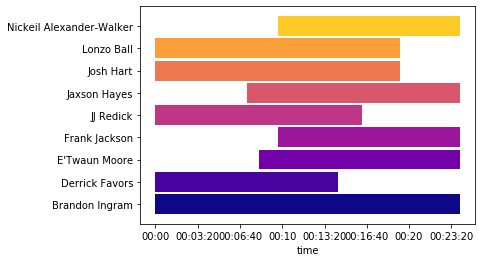

In [142]:
#Define params and run query   

team = 'NOP'
game_id = '21900626'
period = 1

gameflow(team, game_id, period)

In [16]:
def lineup_correl(team, home_away, start_date, end_date, inc_players, exc_players, player, threshold):
    temp_df = filter_team(team)
    temp_df = filter_home_away(home_away, temp_df)
    temp_df = filter_date(start_date, end_date, temp_df)
    temp_df = filter_included_players(inc_players, temp_df)
    temp_df = filter_excluded_players(exc_players, temp_df)
    temp_df = temp_df[temp_df['team_lineup'].str.contains(player)]

    teammates = temp_df['team_lineup'].unique()
    teammates = teammates.tolist()
    teammates = [i.split(", ") for i in teammates]
    flat_teammates = [item for sublist in teammates for item in sublist]
    flat_teammates = list(dict.fromkeys(flat_teammates))
    
    minutes_logged = []
    
    for i in flat_teammates:
        temp_df['play_length'] = pd.to_datetime(temp_df['play_length'], format='%H:%M:%S')
        player_correl = temp_df[temp_df['team_lineup'].str.contains(i)]
        plays = player_correl['play_length'].dt.second.sum()
        plays = round(plays / 60,2)
        total = temp_df['play_length'].dt.second.sum()
        total = round(total / 60,2)
        minutes_logged.append(round(plays/total,2))
        
    lineup_log = list(zip(flat_teammates, minutes_logged))
    
    if threshold > 0:
        lineup_log = [i for i in lineup_log if i[1] >= threshold]
        
    else:
        lineup_log = lineup_log
    
    return lineup_log
  

In [17]:
#Define params and run query   

team = 'NOP'
home_away = ''
start_date = ''
end_date = ''
inc_players = []
exc_players = []
player = "Josh Hart"
threshold = 0.2

lineup_correl(team, home_away, start_date, end_date, inc_players, exc_players, player, threshold)

[('Jrue Holiday', 0.43),
 ('Brandon Ingram', 0.56),
 ('Derrick Favors', 0.26),
 ('JJ Redick', 0.39),
 ('Josh Hart', 1.0),
 ('Jahlil Okafor', 0.22),
 ("E'Twaun Moore", 0.3),
 ('Nickeil Alexander-Walker', 0.2),
 ('Kenrich Williams', 0.27),
 ('Nicolo Melli', 0.21),
 ('Frank Jackson', 0.2),
 ('Lonzo Ball', 0.59),
 ('Jaxson Hayes', 0.37)]

In [18]:
def get_DraftKings(url):
    file = pd.read_csv(url)
    
    return file

In [19]:
url = 'https://www.draftkings.com/lineup/getavailableplayerscsv?contestTypeId=73&draftGroupId=33445'

get_DraftKings(url)

,Position,Name + ID,Name,ID,Roster Position,Game Info,TeamAbbrev,AvgPointsPerGame
0,SF,Kawhi Leonard (14229259) (LOCKED),Kawhi Leonard,14229259,T1,Final,LAC,49.65
1,SG/SF,Bradley Beal (14229260) (LOCKED),Bradley Beal,14229260,T1,Final,WAS,46.93
2,C,Karl-Anthony Towns (14229258) (LOCKED),Karl-Anthony Towns,14229258,T1,Final,MIN,52.09
3,PG,Trae Young (14229261) (LOCKED),Trae Young,14229261,T1,Final,ATL,50.85
4,C,Joel Embiid (14229264) (LOCKED),Joel Embiid,14229264,T2,Final,PHI,47.24
5,PG/SF,Ben Simmons (14229265) (LOCKED),Ben Simmons,14229265,T2,Final,PHI,43.60
6,PF/C,Domantas Sabonis (14229262) (LOCKED),Domantas Sabonis,14229262,T2,Final,IND,43.83
7,C,Andre Drummond (14229263) (LOCKED),Andre Drummond,14229263,T2,Final,DET,48.22
8,C,Bam Adebayo (14229270) (LOCKED),Bam Adebayo,14229270,T3,Final,MIA,40.44
9,PG/SG,D'Angelo Russell (14229266) (LOCKED),D'Angelo Russell,14229266,T3,Final,GS,40.66


In [20]:
def getTeam(url):
    temp_df = pd.read_csv(url)
    
    player_list = temp_df['Name'].tolist()
    
    team_list = []
    
    
    for p in player_list:
        player_team = temp_df.loc[temp_df['Name']==p, 'TeamAbbrev'].iloc[0]
        
        team_list.append(player_team)
    
    temp_dict = dict(zip(player_list, team_list))
    
    return temp_dict
        

In [21]:
url = 'https://www.draftkings.com/lineup/getavailableplayerscsv?contestTypeId=73&draftGroupId=33437'


player_pool = getTeam(url)

print(player_pool)

{'Giannis Antetokounmpo': 'MIL', 'Devin Booker': 'PHO', 'James Harden': 'HOU', 'Russell Westbrook': 'HOU', 'Pascal Siakam': 'TOR', 'Zach LaVine': 'CHI', 'Khris Middleton': 'MIL', 'Jrue Holiday': 'NO', 'Fred VanVleet': 'TOR', 'Kyle Lowry': 'TOR', 'Deandre Ayton': 'PHO', 'Zion Williamson': 'NO', 'Brandon Ingram': 'NO', 'Serge Ibaka': 'TOR', 'Thaddeus Young': 'CHI', 'Eric Bledsoe': 'MIL', 'Kelly Oubre Jr.': 'PHO', 'Lonzo Ball': 'NO', 'Eric Gordon': 'HOU', 'OG Anunoby': 'TOR', 'Tomas Satoransky': 'CHI', 'Marc Gasol': 'TOR', 'Ricky Rubio': 'PHO', 'Ersan Ilyasova': 'MIL', 'Derrick Favors': 'NO', 'P.J. Tucker': 'HOU', 'Kris Dunn': 'CHI', 'Coby White': 'CHI', 'Luke Kornet': 'CHI', 'Mikal Bridges': 'PHO', 'Donte DiVincenzo': 'MIL', 'Brook Lopez': 'MIL', 'Danuel House Jr.': 'HOU', 'Josh Hart': 'NO'}


In [25]:
def get_games_played(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = ['Young']
        exc_players = ['Bembry', 'Reddish', 'Len']
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_games = temp_df['GP']
        
        return player_games

def get_minutes(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_mins = temp_df['MIN']
        
        return player_mins
    
def get_points(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_points = temp_df['PTS']
        
        return player_points  

def get_fga(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_fga = temp_df['FGA']
        
        return player_fga
    
def get_fgm(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_fgm = temp_df['FGM']
        
        return player_fgm  

def get_fg_per(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_fg_per = temp_df['FG%']
        
        return player_fg_per 

    
def get_mpg(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_mpg = temp_df['MPG']
        
        return player_mpg
    

def get_assists(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_assists = temp_df['AST']
        
        return player_assists
    
    
def get_tpm(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_tpm = temp_df['TPM']
        
        return player_tpm

    
def get_boards(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_boards = temp_df['REB']
        
        return player_boards
    
    
def get_blocks(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_blocks = temp_df['BLK']

        return player_blocks
    
    
def get_steals(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_steals = temp_df['STL']

        return player_steals    
    
    
def get_turnovers(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_turnovers = temp_df['TOV']

        return player_turnovers      
    
    
def get_unassisted(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_unassisted = temp_df['UA']

        return player_unassisted      
    
    
def get_assisted(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_assisted = temp_df['A']

        return player_assisted      
    

def get_assist_per(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_assist_per = temp_df['%A']

        return player_assist_per    
    
def simulate_shot(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        
        #Percentage of FGA at distance
        
        zero_odds = temp_df.loc[temp_df['Player'] == name, '% 0-3'].values[0]
        four_odds = temp_df.loc[temp_df['Player'] == name, '% 4-9'].values[0]
        ten_odds = temp_df.loc[temp_df['Player'] == name, '% 10-15'].values[0]
        sixteen_odds = temp_df.loc[temp_df['Player'] == name, '% 16-23'].values[0]
        twentyfour_odds = temp_df.loc[temp_df['Player'] == name, '% 24-29'].values[0]
        thirty_odds = temp_df.loc[temp_df['Player'] == name, '% 30+'].values[0]
        
        #Shot Percentages
        
        zero_per = temp_df.loc[temp_df['Player'] == name, '0-3 FG%'].values[0]
        four_per = temp_df.loc[temp_df['Player'] == name, '4-9 FG%'].values[0]
        ten_per = temp_df.loc[temp_df['Player'] == name, '10-15 FG%'].values[0]
        sixteen_per = temp_df.loc[temp_df['Player'] == name, '16-23 FG%'].values[0]
        twentyfour_per = temp_df.loc[temp_df['Player'] == name, '24-29 FG%'].values[0]
        thirty_per = temp_df.loc[temp_df['Player'] == name, '30+ FG%'].values[0]
        
        
        
        shot_options = ['0-3', '4-9', '10-15', '16-23', '24-29', '30+'] 
        shot_dict = [zero_odds, four_odds, ten_odds, sixteen_odds, twentyfour_odds, thirty_odds]
        per_dict = [zero_per, four_per, ten_per, sixteen_per, twentyfour_per, thirty_per]
                     
        shot_choices = np.random.choice(shot_options, 19, shot_dict)
        
        relations = dict(zip(shot_options, per_dict))
        
        shot_odds = np.array([relations[x] for x in shot_choices]) # np.array optional
        
        shot_dictionary = []
        
        for p in shot_odds:
            trials = binom.rvs(n=100, p=p, size=20)
            trials = np.mean(trials)
            shot_dictionary.append(trials)
            
        return shot_dictionary

        

In [26]:
class Player():
    
    def __init__(self, name, team):
        self.name = name
        self.team = team
        self.games = get_games_played(team, name)
        self.minutes = get_minutes(team, name)
        self.mpg = get_mpg(team, name)
        self.points = get_points(team, name)        
        self.fga = get_fga(team, name)        
        self.fgm = get_fgm(team, name)
        self.fg_per = get_fg_per(team, name)
        self.TPM = get_tpm(team, name)
        self.AST = get_assists(team, name)
        self.REB = get_boards(team, name)
        self.BLK = get_blocks(team, name)
        self.STL = get_steals(team, name)
        self.TOV = get_turnovers(team, name)
        self.UA = get_unassisted(team, name)
        self.A = get_assisted(team, name)
        self.per_A = get_assist_per(team, name)
        self.simulate_shot = simulate_shot(team, name)


In [27]:
kawhi_LAC = Player("Kawhi Leonard", "LAC")

kawhi_LAC.simulate_shot

ValueError: Length mismatch: Expected axis has 0 elements, new values have 25 elements

In [32]:
team = 'DET'
home_away = ""
start_date = ''
end_date = ''
inc_players = []
exc_players = ['Blake Griffin']

temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))



In [133]:
team = 'DET'
home_away = ""
start_date = ''
end_date = ''
inc_players = []
exc_players = []
player = "Reggie Jackson"
threshold = 0.0



lineup_correl(team, home_away, start_date, end_date, inc_players, exc_players, player, threshold)

[('Tony Snell', 0.68),
 ('Markieff Morris', 0.89),
 ('Andre Drummond', 0.89),
 ('Bruce Brown', 0.71),
 ('Reggie Jackson', 1.0),
 ('Luke Kennard', 0.35),
 ('Langston Galloway', 0.37),
 ('Thon Maker', 0.11)]

In [93]:
group =  [['apple', 'cherry'], ['apple', 'tomato'], ['tomato', 'persimmon'],['cherry', 'persimmon'], ['apple', 'tomato'], ['grape', 'kiwi'], ['lemon', 'apple']]

cost = [[1.80], [3.10], [5.44], [6.23], [1.25], [0.94], [1.08]]

fruits =  pd.DataFrame(zip(group, cost))

print(fruits)

                     0       1
0      [apple, cherry]   [1.8]
1      [apple, tomato]   [3.1]
2  [tomato, persimmon]  [5.44]
3  [cherry, persimmon]  [6.23]
4      [apple, tomato]  [1.25]
5        [grape, kiwi]  [0.94]
6       [lemon, apple]  [1.08]
